In [1]:
%load_ext lab_black

In [2]:
from traffic.core import Traffic

dublin = Traffic.from_file("EIDW_dataset.parquet.gz")

In [4]:
dublin

,count
flight_id,
VOR05_1616,11717
VOR05_1617,7542
STK51ED_10389,4112
STK265B_15217,3471
PRZIQ_17989,3458
RYR75CC_12895,3294
STK3213_16291,3187
STK19L_15253,3186
STK1K_8549,3060


In [5]:
merge_point = (
    dublin.has("aligned_on_EIDW").has("merge_point_LAPMO").eval(desc="", max_workers=8)
)

  0%|          | 0/17701 [00:00<?, ?it/s]

In [6]:
import random

s2 = merge_point[random.sample(merge_point.flight_ids, 600)]

In [9]:
s2.to_pickle("ireland.pkl")

In [14]:
from pyproj import Geod
from shapely.geometry import Polygon
from cartopy.feature import ShapelyFeature
from cartopy.crs import PlateCarree, OSNI
import numpy as np

geod = Geod(ellps="WGS84")

lon_, lat_, back_ = geod.fwd(
    airports["EIDW"].point.longitude * np.ones(360),
    airports["EIDW"].point.latitude * np.ones(360),
    np.arange(0, 360),
    1852 * 40 * np.ones(360),
)
asma = ShapelyFeature([Polygon(list(zip(lon_, lat_)))], crs=PlateCarree())

In [15]:
import cartopy.io.shapereader as shpreader
from geopandas import GeoDataFrame

countries_10 = GeoDataFrame.from_file(
    shpreader.natural_earth(
        resolution="10m",
        category="cultural",
        name="admin_0_countries",
    )
)
ie = ShapelyFeature(
    countries_10.loc[
        countries_10.intersects(next(asma.geometries()))
    ].geometry.to_list(),
    crs=PlateCarree(),
)
ie_asma = ShapelyFeature(
    countries_10.loc[countries_10.intersects(next(asma.geometries()))]
    .intersection(next(asma.geometries()))
    .to_list(),
    crs=PlateCarree(),
)

In [17]:
from cartes.osm import Nominatim

next(asma.geometries()).bounds

(-7.384402016610596, 52.755638320412864, -5.155737983389403, 54.0868850424813)

In [19]:
from cartes.crs import EPSG_29901, PlateCarree


class OSNI(EPSG_29901):
    bbox = {
        "east_longitude": -3,
        "north_latitude": 55.636,
        "south_latitude": 51.222,
        "west_longitude": -11.013378,
    }


OSNI()

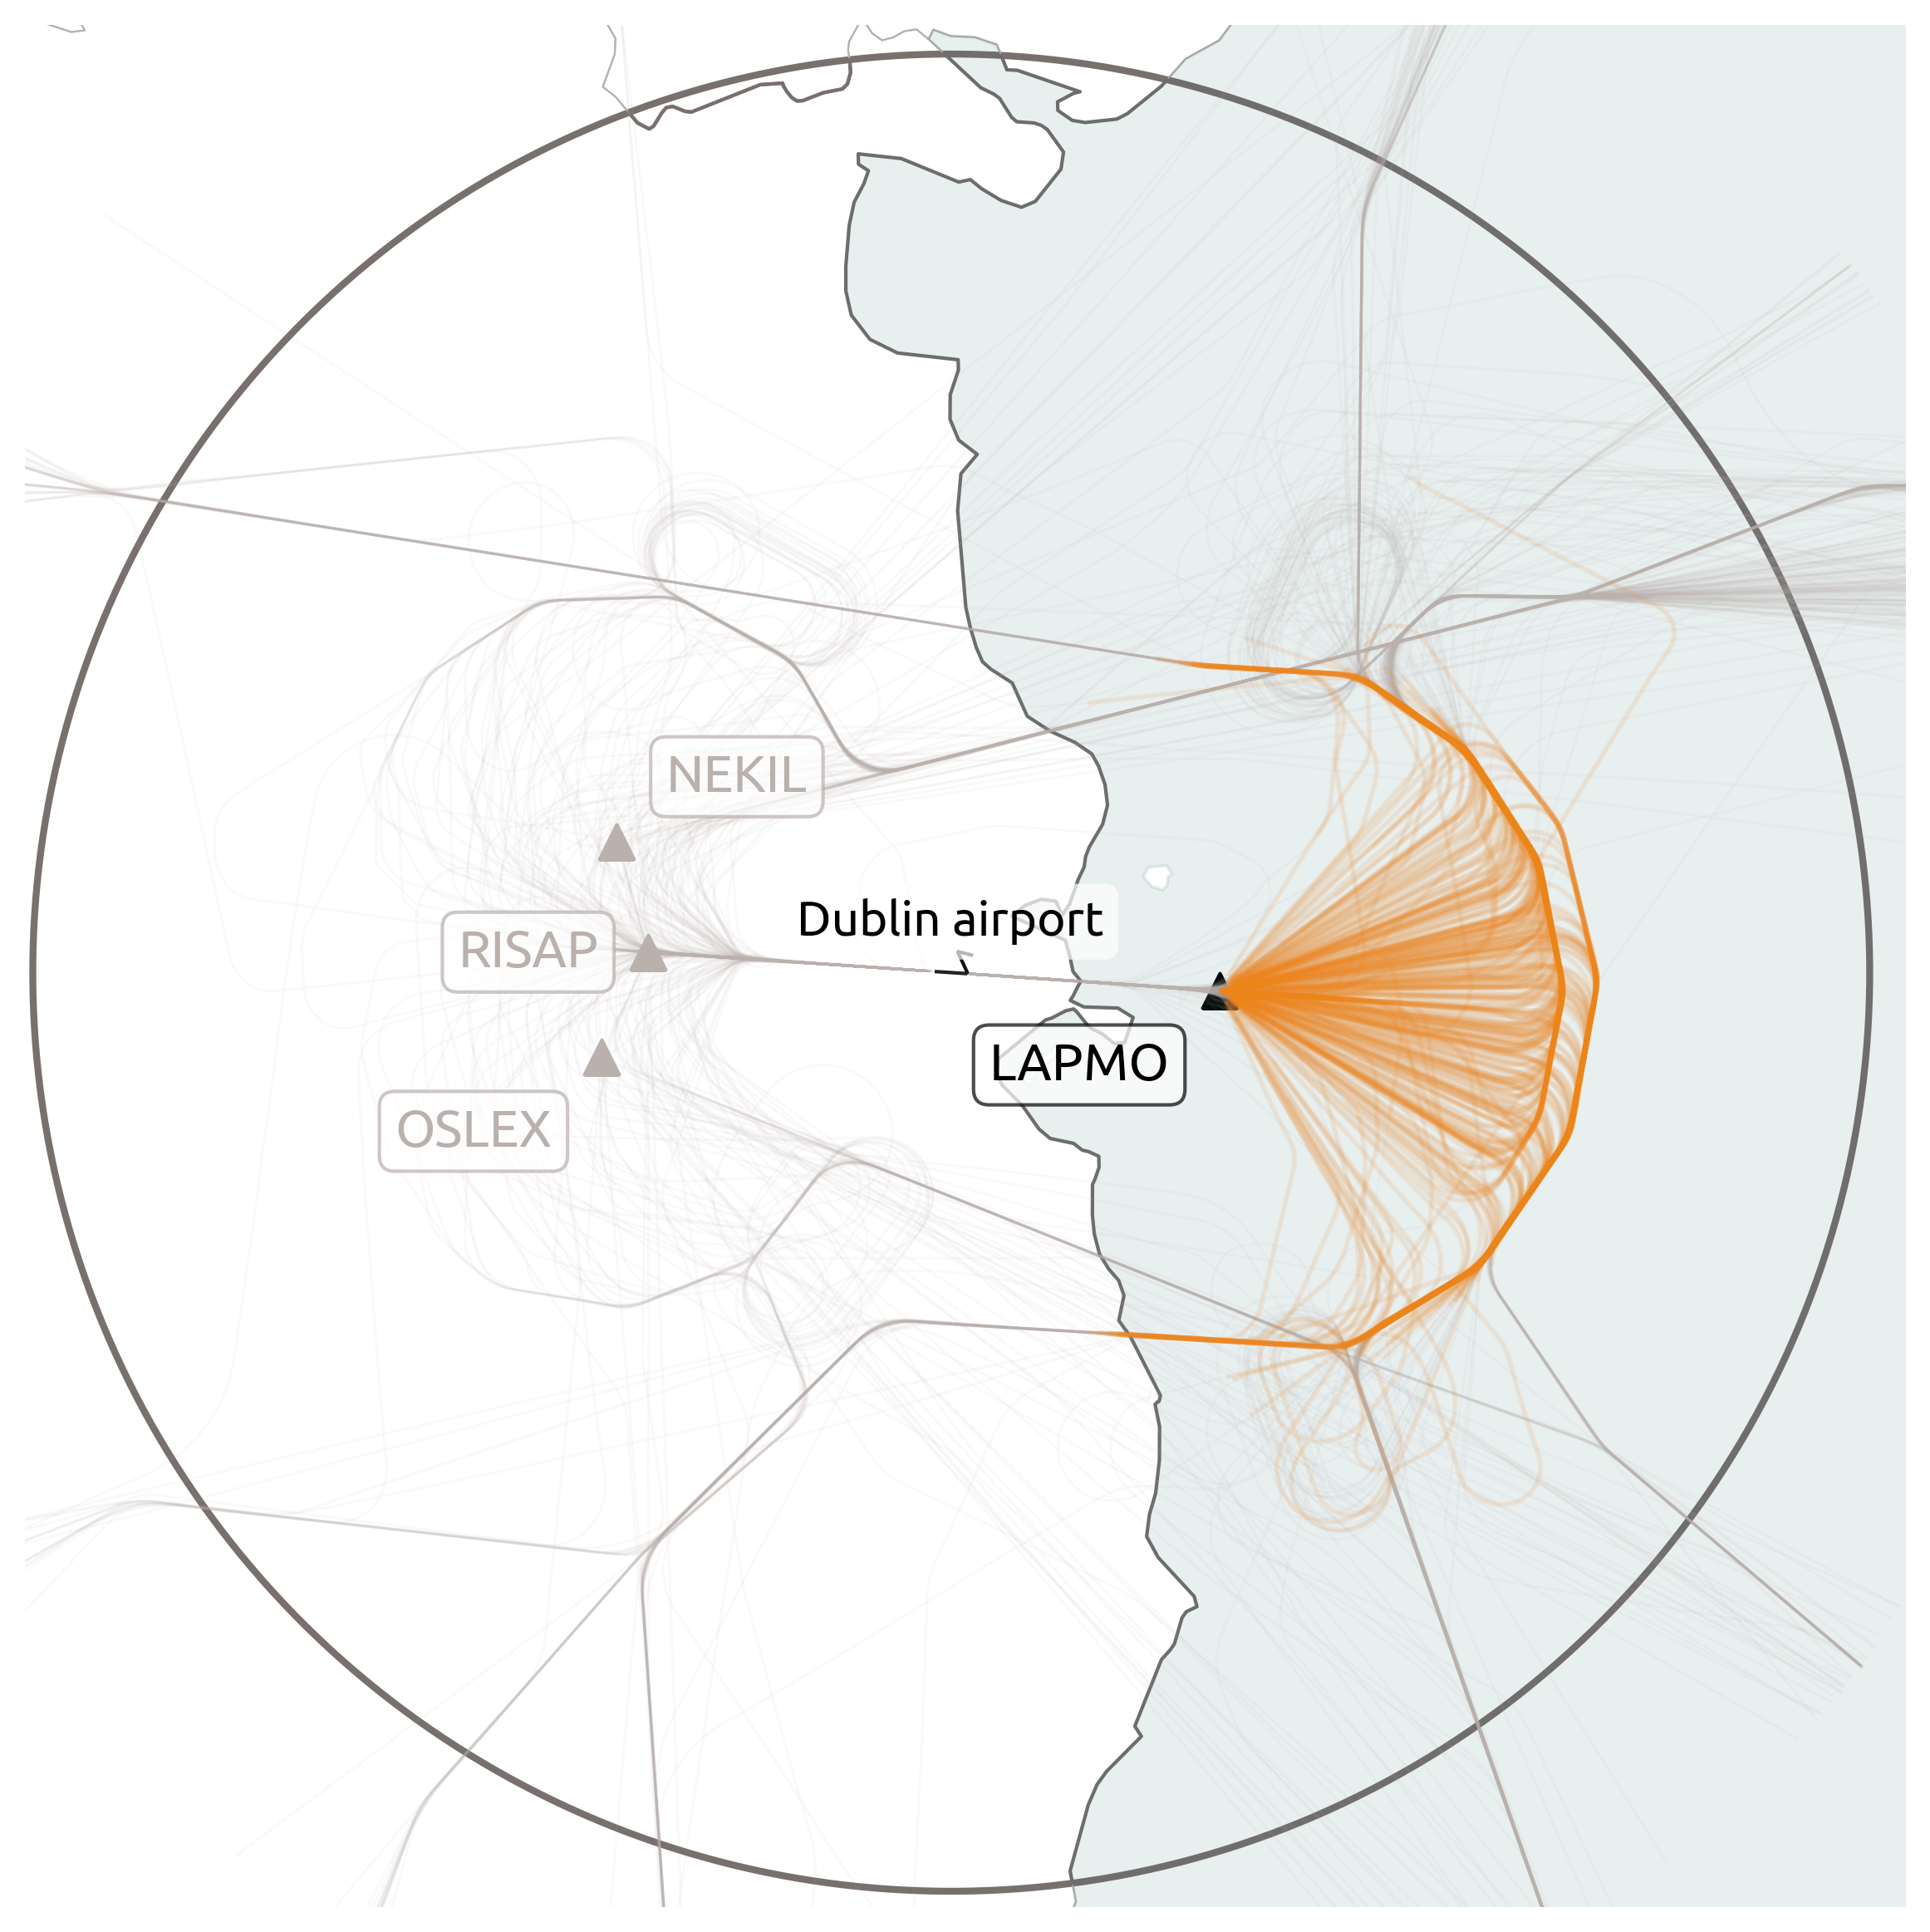

In [60]:
import matplotlib.pyplot as plt

from cartopy.feature import ShapelyFeature
from cartes.utils.features import ocean

from traffic.data import airports, navaids

box_params = dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(
        figsize=(10, 10), dpi=300, subplot_kw=dict(projection=OSNI())
    )

    ax.add_feature(asma, edgecolor="#79706e", facecolor="none", linewidth=2)
    ax.add_feature(ie, edgecolor="#bab0ac", facecolor="none", linewidth=0.5)
    ax.add_feature(ie_asma, edgecolor="#79706e", facecolor="none", linewidth=1)
    ax.add_feature(ocean(scale="10m", alpha=0.1))

    s2.plot(ax, color="#bab0ac", alpha=0.07, linewidth=0.7)

    airports["EIDW"].plot(ax, footprint=False, runways=dict(linewidth=1))

    ap = airports["EIDW"].point
    ax.text(
        ap.longitude,
        ap.latitude + 0.02,
        "Dublin airport",
        ha="center",
        va="bottom",
        font="Ubuntu",
        fontsize=14,
        transform=PlateCarree(),
        bbox=dict(
            boxstyle="round", zorder=5, edgecolor="none", facecolor="white", alpha=0.7
        ),
    )

    for flight in s2:
        aligned = flight.aligned_on_EIDW().next()

        if aligned.ILS_max == "28L":
            for segment in flight.merge_point(navaids["LAPMO"]):
                segment.plot(ax, color="#f58518", alpha=0.1)

    navaids["LAPMO"].plot(
        ax,
        marker="^",
        shift=dict(units="dots", x=-20 * 3, y=-20 * 3),
        text_kw=dict(
            ha="right",
            va="top",
            fontname="Ubuntu",
            fontsize=15,
            bbox=box_params,
        ),
    )
    navaids["NEKIL"].plot(
        ax,
        marker="^",
        color="#bab0ac",
        shift=dict(units="dots", x=20 * 3, y=20 * 3),
        text_kw=dict(
            fontname="Ubuntu",
            fontsize=15,
            color="#bab0ac",
            bbox={**box_params, **dict(edgecolor="#bab0ac")},
        ),
    )
    navaids["OSLEX"].plot(
        ax,
        marker="^",
        color="#bab0ac",
        shift=dict(units="dots", x=-20 * 3, y=-20 * 3),
        text_kw=dict(
            ha="right",
            va="top",
            fontname="Ubuntu",
            fontsize=15,
            color="#bab0ac",
            bbox={**box_params, **dict(edgecolor="#bab0ac")},
        ),
    )
    navaids["RISAP"].plot(
        ax,
        marker="^",
        color="#bab0ac",
        shift=dict(units="dots", x=-20 * 3, y=0 * 3),
        text_kw=dict(
            ha="right",
            va="center",
            fontname="Ubuntu",
            color="#bab0ac",
            fontsize=15,
            bbox={**box_params, **dict(edgecolor="#bab0ac")},
        ),
    )
    
    ax.set_extent((-7.3844, -5.156, 52.755, 54.087))
    fig.savefig("pointmerge_eidw.png", dpi=300, transparent=False)
    